# 🏠 Real Estate Price Prediction

This notebook walks through an end-to-end regression project using Melbourne housing data. We’ll explore and clean the data, transform skewed targets, train and compare several models, tune hyperparameters, and use explainability tools to understand feature impacts.


## Install and Import Required Libraries

Install required packages and import all necessary libraries used for preprocessing, modeling, evaluation, and deployment.


In [1]:
# Install required packages
!pip install --upgrade scikit-learn xgboost lightgbm shap gradio
!pip install joblib

# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import warnings
import joblib

# Statistical and ML tools
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.12.1
    Uninstalling gradio_client-1.12.1:
      Successfully uninstalled gradio_client-1.12.1
  Attempting uninstall: gradio
    Found existing installation: gradio 5.44.1
    Uninstalling gradio-5.44.1:
      Successfully uninstalled gradio-5.44.1


## Load the Dataset

Load the dataset from a public GitHub URL. Display sample rows and check column types and missing values.


In [2]:
# Load dataset from remote CSV file
file_url = "https://raw.githubusercontent.com/svvd-m/real-estate-price-prediction/main/DATA2.csv"
df = pd.read_csv(file_url)

# Show first 10 rows
print("Dataset loaded. Sample rows:")
display(df.head(10))

# Overview of column data types
print("Data Info:")
df.info()

# Count missing values per column
print("\nMissing Values per Column:")
display(df.isnull().sum())


Dataset loaded. Sample rows:


,Sl no,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,1,Abbotsford,85 Turner St,2,h,1480000,S,Biggin,03-12-16,2.5,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,2,Abbotsford,25 Bloomburg St,2,h,1035000,S,Biggin,04-02-16,2.5,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,4,Abbotsford,5 Charles St,3,h,1465000,SP,Biggin,04-03-17,2.5,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,5,Abbotsford,40 Federation La,3,h,850000,PI,Biggin,04-03-17,2.5,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,6,Abbotsford,55a Park St,4,h,1600000,VB,Nelson,04-06-16,2.5,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0
5,10,Abbotsford,129 Charles St,2,h,941000,S,Jellis,07-05-16,2.5,...,1.0,0.0,181.0,NaN,NaN,Yarra,-37.8041,144.9953,Northern Metropolitan,4019.0
6,11,Abbotsford,124 Yarra St,3,h,1876000,S,Nelson,07-05-16,2.5,...,2.0,0.0,245.0,210.0,1910.0,Yarra,-37.8024,144.9993,Northern Metropolitan,4019.0
7,14,Abbotsford,98 Charles St,2,h,1636000,S,Nelson,08-10-16,2.5,...,1.0,2.0,256.0,107.0,1890.0,Yarra,-37.8060,144.9954,Northern Metropolitan,4019.0
8,15,Abbotsford,217 Langridge St,3,h,1000000,S,Jellis,08-10-16,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northern Metropolitan,4019.0
9,16,Abbotsford,18a Mollison St,2,t,745000,S,Jellis,08-10-16,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northern Metropolitan,4019.0


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18396 entries, 0 to 18395
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sl no          18396 non-null  int64  
 1   Suburb         18396 non-null  object 
 2   Address        18396 non-null  object 
 3   Rooms          18396 non-null  int64  
 4   Type           18396 non-null  object 
 5   Price          18396 non-null  int64  
 6   Method         18396 non-null  object 
 7   SellerG        18396 non-null  object 
 8   Date           18396 non-null  object 
 9   Distance       18395 non-null  float64
 10  Postcode       18395 non-null  float64
 11  Bedroom2       14927 non-null  float64
 12  Bathroom       14925 non-null  float64
 13  Car            14820 non-null  float64
 14  Landsize       13603 non-null  float64
 15  BuildingArea   7762 non-null   float64
 16  YearBuilt      8958 non-null   float64
 17  CouncilArea    12233 non-null  object 


,0
Sl no,0
Suburb,0
Address,0
Rooms,0
Type,0
Price,0
Method,0
SellerG,0
Date,0
Distance,1


## Remove Outliers

Remove the top 1% most expensive houses to reduce skew and improve model reliability.


In [3]:
# Define threshold for top 1% prices
price_threshold = df['Price'].quantile(0.99)

# Keep only rows below the threshold
df = df[df['Price'] <= price_threshold]

# Output new dataset shape and max price
print(f"Dataset size after outlier removal: {df.shape}")
print(f"New maximum price after removing outliers: {df['Price'].max():.2f}")


Dataset size after outlier removal: (18217, 22)
New maximum price after removing outliers: 3400000.00


## Normalize the Target Variable

Apply various transformations to normalize the distribution of the 'Price' column. Yeo-Johnson is selected for its flexibility with skewed data.


Skewness: 1.37
Kurtosis: 2.07


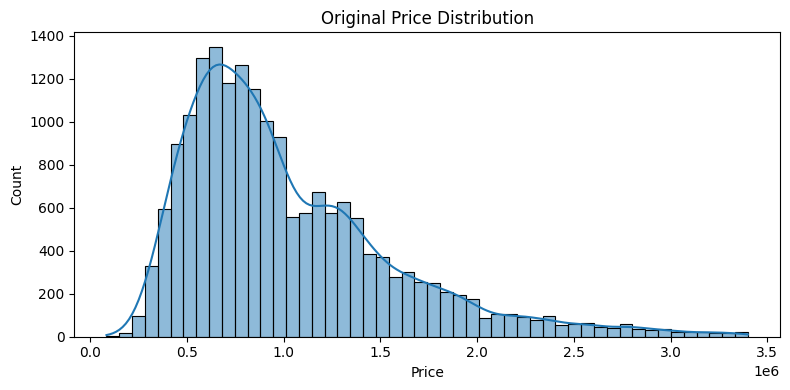

Price: skew=1.374, kurtosis=2.068
Log_Price: skew=0.106, kurtosis=-0.299
SQRT_Price: skew=0.734, kurtosis=0.293
BoxCox_Price: skew=0.004, kurtosis=-0.273
Yeo_Price: skew=0.004, kurtosis=-0.273


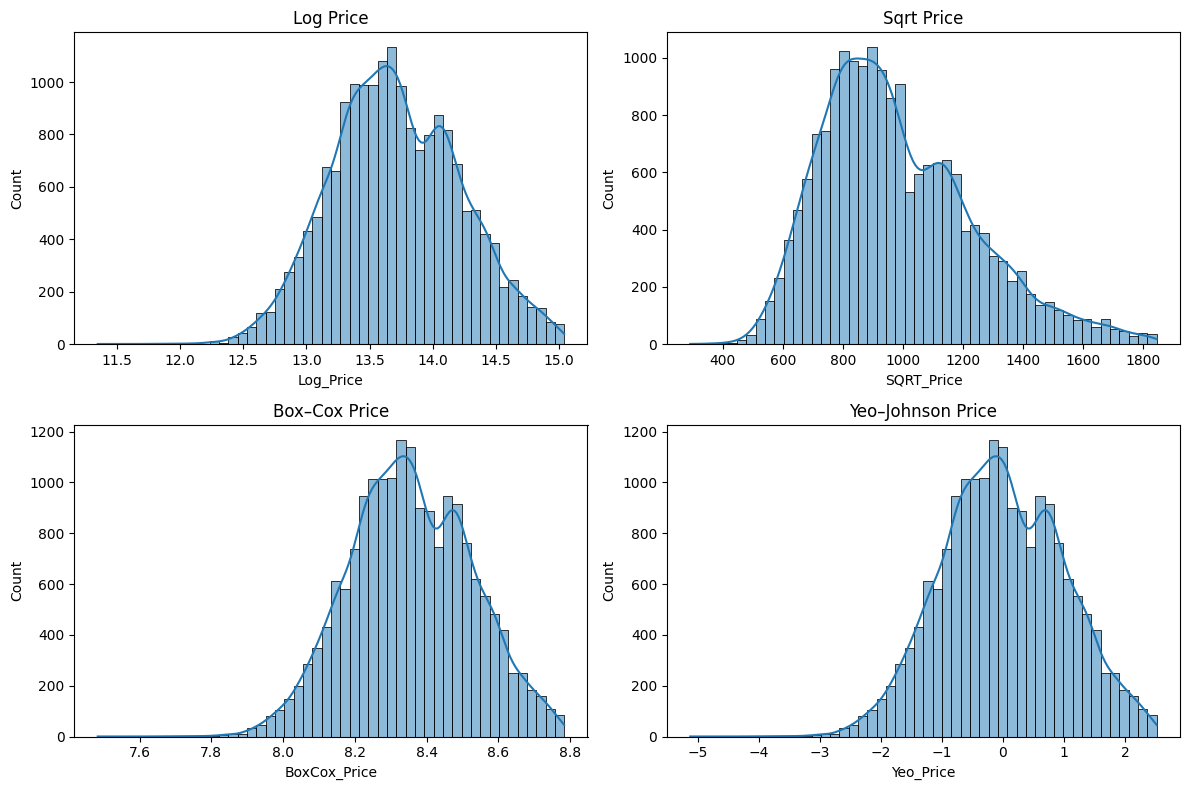

Price column normalized with Yeo–Johnson.


In [4]:
# Analyze skewness and kurtosis
print(f"Skewness: {df['Price'].skew():.2f}")
print(f"Kurtosis: {df['Price'].kurtosis():.2f}")

# Plot original distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Original Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Apply different transformations
df['Log_Price'] = np.log1p(df['Price'])
df['SQRT_Price'] = np.sqrt(df['Price'])
df['BoxCox_Price'], _ = boxcox(df['Price'] + 1)
yj = PowerTransformer(method='yeo-johnson')
df['Yeo_Price'] = yj.fit_transform(df[['Price']])

# Print skew and kurtosis for each transformed column
for col in ['Price','Log_Price','SQRT_Price','BoxCox_Price','Yeo_Price']:
    print(f"{col}: skew={df[col].skew():.3f}, kurtosis={df[col].kurtosis():.3f}")

# Plot histograms of each transformation
fig, axes = plt.subplots(2,2,figsize=(12,8))
sns.histplot(df['Log_Price'], bins=50, kde=True, ax=axes[0,0]).set_title("Log Price")
sns.histplot(df['SQRT_Price'], bins=50, kde=True, ax=axes[0,1]).set_title("Sqrt Price")
sns.histplot(df['BoxCox_Price'], bins=50, kde=True, ax=axes[1,0]).set_title("Box–Cox Price")
sns.histplot(df['Yeo_Price'], bins=50, kde=True, ax=axes[1,1]).set_title("Yeo–Johnson Price")
plt.tight_layout()
plt.show()

# Finalize Yeo–Johnson as the target transformation
df['Price'] = df['Yeo_Price']
df.drop(columns=['Log_Price', 'SQRT_Price', 'BoxCox_Price', 'Yeo_Price'], inplace=True)
print("Price column normalized with Yeo–Johnson.")


## Drop Unnecessary Columns and Fill Missing Values

Remove irrelevant columns from the dataset. Fill missing values in numerical columns with medians and in categorical columns with modes.


In [5]:
# List of columns to drop
drop_cols = ['Sl no', 'Address', 'Method', 'SellerG', 'Date', 'Postcode', 'Bedroom2']
for c in drop_cols:
    if c in df:
        df.drop(columns=c, inplace=True)
print("Dropped unnecessary columns.")

# Define numeric and categorical columns to process
num_cols = ['Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
            'Lattitude', 'Longtitude', 'Propertycount']
cat_cols = ['CouncilArea', 'Regionname', 'Type', 'Suburb']

# Fill missing numeric values with medians
for c in num_cols:
    if c in df:
        df[c].fillna(df[c].median(), inplace=True)

# Fill missing categorical values with modes
for c in cat_cols:
    if c in df:
        df[c].fillna(df[c].mode()[0], inplace=True)

print("Missing values filled.")


Dropped unnecessary columns.
Missing values filled.


## Define Features and Target, Split Dataset

Separate the target variable (`Price`) from the features, then split the dataset into training and testing subsets.


In [6]:
# Define target and features
y = df['Price']
X = df.drop('Price', axis=1)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Encode Categorical Variables and Scale Features

Apply one-hot encoding to categorical columns.  
Align train and test sets to the same columns, then scale numerical features using standard scaling.


In [7]:
# Define categorical columns to encode
cat_cols = ['Type', 'Suburb', 'CouncilArea', 'Regionname']

# One-hot encode and drop first category
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Align train and test sets to ensure same feature structure
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display shapes
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")


Training set shape: (14573, 375)
Testing set shape: (3644, 375)


## Define Models and Evaluation Function

Set up four machine learning models for comparison.  
Also define a helper function to compute R², MAE, and RMSE for consistent evaluation.


In [8]:
# Define models to test
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, random_state=42)
}

# Define evaluation function for model comparison
def evaluate_model(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    tr_r2 = model.score(X_tr, y_tr)
    te_r2 = model.score(X_te, y_te)
    mae = mean_absolute_error(y_te, model.predict(X_te))
    rmse = np.sqrt(mean_squared_error(y_te, model.predict(X_te)))
    return tr_r2, te_r2, mae, rmse


## Train and Evaluate Models

Train each model and compare performance using test R², MAE, and RMSE metrics.


In [9]:
# Evaluate all models and compare their performance metrics
results = {}

for name, mdl in models.items():
    if name == "LightGBM":
        mdl.set_params(verbose=-1)  # Suppress LightGBM training output

    tr, te, mae, rmse = evaluate_model(mdl, X_train_scaled, y_train, X_test_scaled, y_test)
    results[name] = [tr, te, mae, rmse]
    print(f"{name}: Test R²={te:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

# Display comparison as a DataFrame
comp_df = pd.DataFrame.from_dict(results, orient='index', columns=['Train R²', 'Test R²', 'MAE', 'RMSE'])
print("\nSummary:")
display(comp_df.sort_values('Test R²', ascending=False))


Linear Regression: Test R²=0.775, MAE=0.37, RMSE=0.47
Random Forest: Test R²=0.843, MAE=0.29, RMSE=0.40
XGBoost: Test R²=0.856, MAE=0.28, RMSE=0.38
LightGBM: Test R²=0.862, MAE=0.28, RMSE=0.37

Summary:


,Train R²,Test R²,MAE,RMSE
LightGBM,0.887300,0.861878,0.278481,0.371974
XGBoost,0.913305,0.855785,0.283173,0.380090
Random Forest,0.963634,0.843497,0.290767,0.395952
Linear Regression,0.775975,0.775399,0.365448,0.474338


## Cross-Validation

Run 5-fold cross-validation to assess generalization and variance in model performance.


Running 5-fold cross-validation on each model...
Linear Regression: mean R² = 0.750, std = 0.026
Random Forest: mean R² = 0.830, std = 0.006
XGBoost: mean R² = 0.845, std = 0.006
LightGBM: mean R² = 0.849, std = 0.006


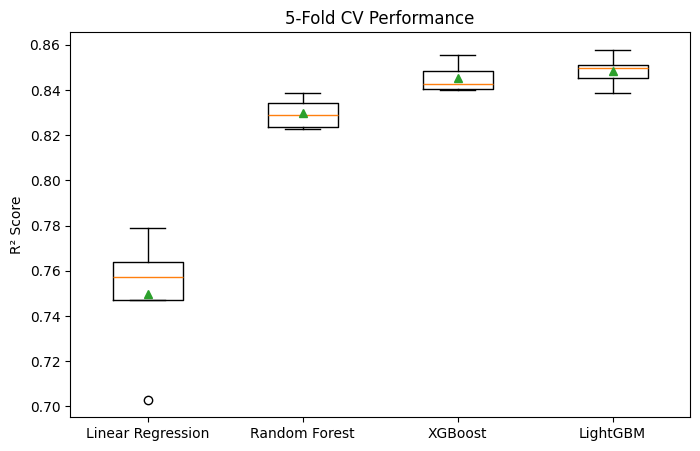

In [10]:
# Perform 5-fold cross-validation and visualize model performance
print("Running 5-fold cross-validation on each model...")

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2", n_jobs=-1)
    cv_results[name] = scores
    print(f"{name}: mean R² = {scores.mean():.3f}, std = {scores.std():.3f}")

# Plot results
plt.figure(figsize=(8,5))
plt.boxplot(cv_results.values(), labels=cv_results.keys(), showmeans=True)
plt.ylabel("R² Score")
plt.title("5-Fold CV Performance")
plt.show()


## SHAP Analysis

Use SHAP to visualize feature influence for the XGBoost and LightGBM models.


XGBoost SHAP summary:


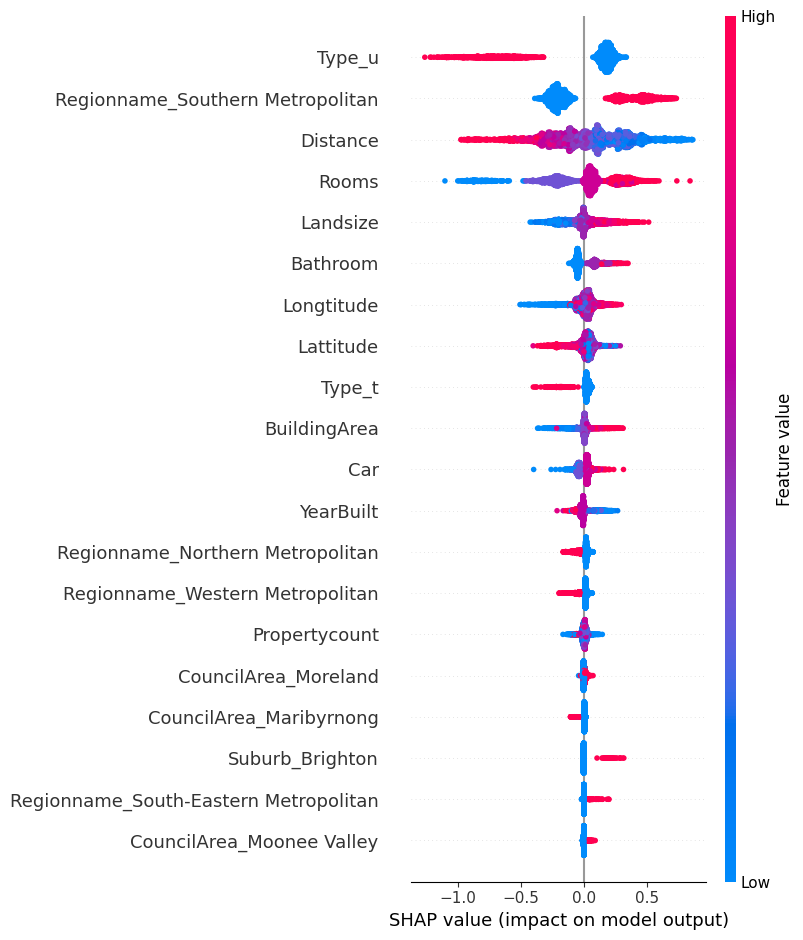

LightGBM SHAP summary:


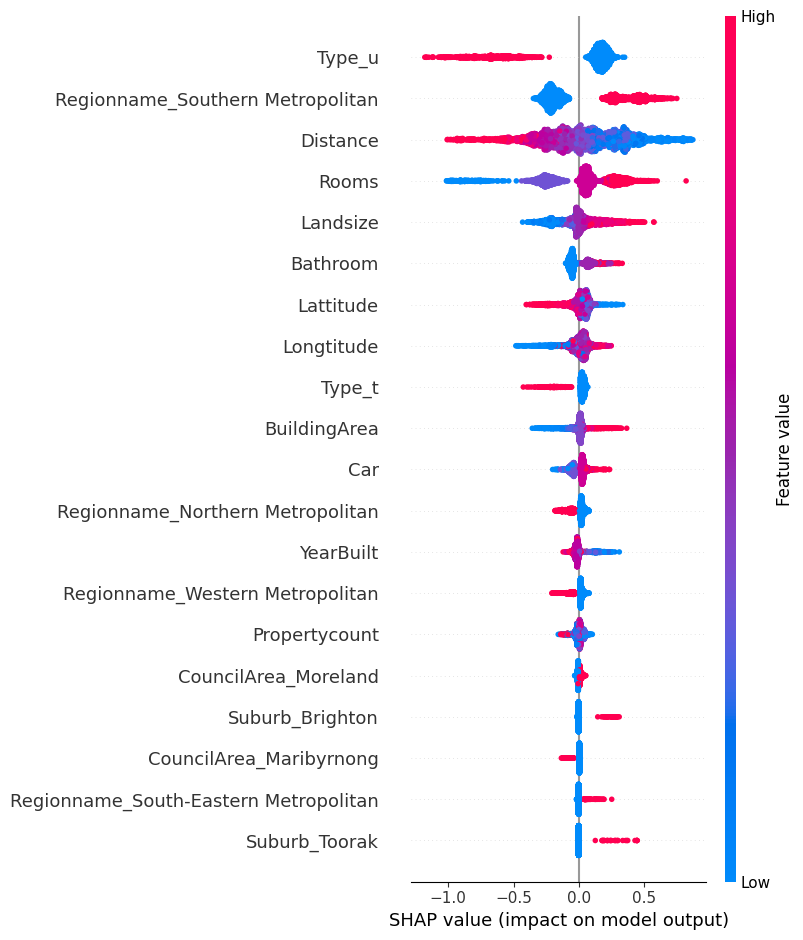

In [11]:
# SHAP for XGBoost
xgb_explainer = shap.TreeExplainer(models["XGBoost"])
sv_xgb = xgb_explainer.shap_values(X_test_scaled)
print("XGBoost SHAP summary:")
shap.summary_plot(sv_xgb, X_test_scaled, feature_names=X_train.columns)

# SHAP for LightGBM
lgb_explainer = shap.TreeExplainer(models["LightGBM"])
sv_lgb = lgb_explainer.shap_values(X_test_scaled)
print("LightGBM SHAP summary:")
shap.summary_plot(sv_lgb, X_test_scaled, feature_names=X_train.columns)


## Permutation Importance

Rank features by importance using permutation scores from XGBoost and LightGBM.


In [12]:
# XGBoost importance
perm_xgb = permutation_importance(models["XGBoost"], X_test_scaled, y_test, n_repeats=5, random_state=42)
imp_xgb = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_xgb.importances_mean
}).sort_values("Importance", ascending=False)
print("Top XGBoost features:")
display(imp_xgb.head(10))

# LightGBM importance
perm_lgb = permutation_importance(models["LightGBM"], X_test_scaled, y_test, n_repeats=5, random_state=42)
imp_lgb = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_lgb.importances_mean
}).sort_values("Importance", ascending=False)
print("Top LightGBM features:")
display(imp_lgb.head(10))


Top XGBoost features:


,Feature,Importance
1,Distance,0.306681
11,Type_u,0.241112
0,Rooms,0.238982
372,Regionname_Southern Metropolitan,0.202362
4,Landsize,0.068026
8,Longtitude,0.040711
7,Lattitude,0.033850
2,Bathroom,0.025335
5,BuildingArea,0.021575
10,Type_t,0.018593


Top LightGBM features:


,Feature,Importance
1,Distance,0.304369
11,Type_u,0.246390
0,Rooms,0.233577
372,Regionname_Southern Metropolitan,0.187777
4,Landsize,0.076905
8,Longtitude,0.037509
7,Lattitude,0.029575
5,BuildingArea,0.023506
2,Bathroom,0.021424
10,Type_t,0.019669


## Hyperparameter Tuning

Use GridSearchCV to find the best performing parameters for XGBoost and LightGBM.


In [13]:
# Perform hyperparameter tuning for XGBoost and LightGBM using GridSearchCV
xgb_grid = {
    "n_estimators": [300, 500],
    "max_depth": [6, 8],
    "learning_rate": [0.1, 0.05],
    "colsample_bytree": [0.8, 1.0],
    "subsample": [0.8, 1.0]
}

xgb_search = GridSearchCV(XGBRegressor(random_state=42), xgb_grid, scoring="r2", cv=3, n_jobs=-1)
xgb_search.fit(X_train_scaled, y_train)
print("Best XGBoost parameters:", xgb_search.best_params_)

lgb_grid = {
    "n_estimators": [300, 500],
    "max_depth": [6, 8],
    "learning_rate": [0.1, 0.05],
    "colsample_bytree": [0.8, 1.0],
    "subsample": [0.8, 1.0]
}

lgb_search = GridSearchCV(LGBMRegressor(random_state=42), lgb_grid, scoring="r2", cv=3, n_jobs=-1)
lgb_search.fit(X_train_scaled, y_train)
print("Best LightGBM parameters:", lgb_search.best_params_)


Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Best LightGBM parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}


## Retrain Tuned Models

Train new XGBoost and LightGBM models with the optimal parameters from GridSearchCV and compare results.


In [14]:
# Evaluate and compare performance of tuned vs. default XGBoost and LightGBM models
xgb_tuned = XGBRegressor(**xgb_search.best_params_, random_state=42)
lgb_tuned = LGBMRegressor(**lgb_search.best_params_, random_state=42)

xgb_tuned.fit(X_train_scaled, y_train)
lgb_tuned.fit(X_train_scaled, y_train)

pred_xgb = xgb_tuned.predict(X_test_scaled)
pred_lgb = lgb_tuned.predict(X_test_scaled)

final = pd.DataFrame({
    "Model": ["XGBoost", "Tuned XGBoost", "LightGBM", "Tuned LightGBM"],
    "MAE": [
        results["XGBoost"][2],
        mean_absolute_error(y_test, pred_xgb),
        results["LightGBM"][2],
        mean_absolute_error(y_test, pred_lgb)
    ],
    "R²": [
        results["XGBoost"][1],
        r2_score(y_test, pred_xgb),
        results["LightGBM"][1],
        r2_score(y_test, pred_lgb)
    ]
})
print("Final comparison:")
display(final)


Final comparison:


,Model,MAE,R²
0,XGBoost,0.283173,0.855785
1,Tuned XGBoost,0.274471,0.862420
2,LightGBM,0.278481,0.861878
3,Tuned LightGBM,0.273659,0.865961


## Save Model and Transformers

Export the trained LightGBM model and preprocessing objects for deployment in the Gradio app.


In [15]:
# Save model and preprocessing artifacts
joblib.dump(lgb_tuned, "lightgbm_price_model.pkl")
joblib.dump(yj, "yeo_johnson_transformer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(list(X_train.columns), "feature_names.pkl")
print("Model and transformers saved.")


Model and transformers saved.


## Deploy with Gradio

Build an interactive Gradio interface that allows users to input property features and receive real-time price predictions.


In [16]:
# Import necessary libraries
import gradio as gr
import pandas as pd
import joblib

# Load trained model and preprocessing artifacts
model = joblib.load("lightgbm_price_model.pkl")
feature_names = joblib.load("feature_names.pkl")
scaler = joblib.load("scaler.pkl")
pt = joblib.load("yeo_johnson_transformer.pkl")

# Define prediction function with input validation, feature preprocessing, and inverse transformation
def predict_price(rooms, distance, landsize, building_area, property_type):
    # ----- Input Validation -----
    if rooms is None or distance is None or landsize is None or building_area is None:
        return "All fields are required. Please fill in all values."

    if any([
        rooms <= 0,
        distance < 0,
        landsize <= 0,
        building_area <= 0
    ]):
        return "Invalid input: all numeric values must be positive and non-zero."

    # Optional clipping to prevent unrealistic extremes
    rooms = min(rooms, 10)
    distance = min(distance, 50)
    landsize = min(landsize, 20000)
    building_area = min(building_area, 1000)

    # Construct input dictionary
    input_dict = {
        'Rooms': rooms,
        'Distance': distance,
        'Landsize': landsize,
        'BuildingArea': building_area,
        'Type_t': 0,
        'Type_u': 0
    }

    if property_type == 'Townhouse':
        input_dict['Type_t'] = 1
    elif property_type == 'Unit':
        input_dict['Type_u'] = 1

    input_df = pd.DataFrame([input_dict])

    # Add any missing columns with zeroes
    for col in feature_names:
        if col not in input_df.columns:
            input_df[col] = 0

    # Ensure column order matches training
    input_df = input_df[feature_names]

    # Scale all features
    input_df = pd.DataFrame(scaler.transform(input_df), columns=input_df.columns)

    # Predict price (Yeo-Johnson transformed)
    price_transformed = model.predict(input_df)[0]

    # Convert back to real-world price
    real_price = pt.inverse_transform([[price_transformed]])[0][0]

    return f"Estimated House Price: ${real_price:,.0f}"

# Define Gradio input fields for the web interface
inputs = [
    gr.Number(label="Number of Rooms", minimum=1, precision=0),
    gr.Number(label="Distance from City Center (km)", minimum=0),
    gr.Number(label="Land Size (sqm)", minimum=1),
    gr.Number(label="Building Area (sqm)", minimum=1),
    gr.Dropdown(choices=["House", "Townhouse", "Unit"], label="Property Type")
]

# Define Gradio output field
outputs = gr.Textbox(label="Predicted House Price")

# Create and configure the Gradio web app interface
app = gr.Interface(
    fn=predict_price,
    inputs=inputs,
    outputs=outputs,
    title="Real Estate Price Predictor",
    description="Enter property features to estimate the sale price."
)

# Launch the app with a shareable link
app.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://62118611598d725437.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://62118611598d725437.gradio.live
